<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>
Using matplotlib as 2D backend.


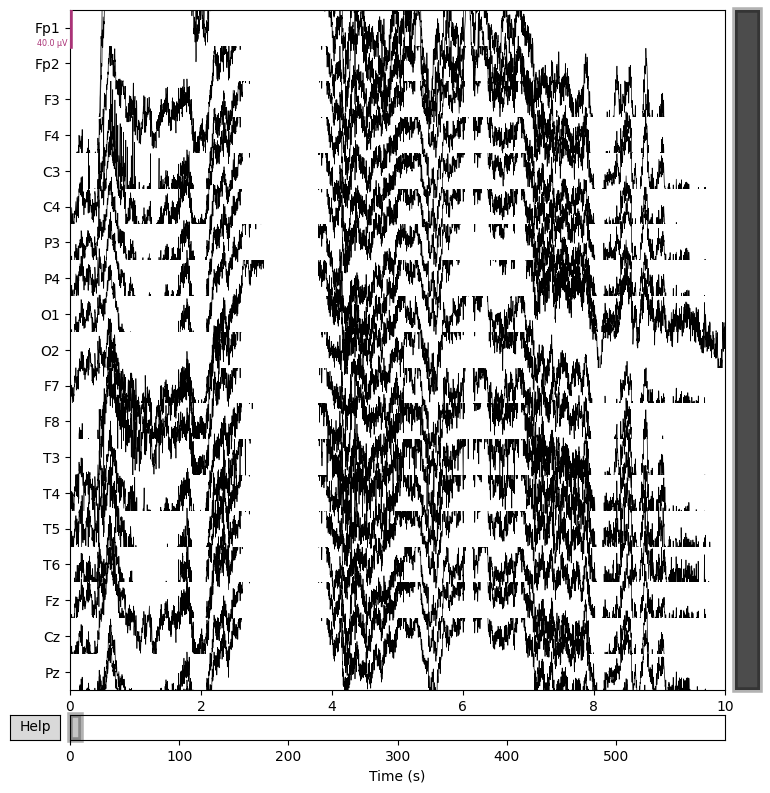

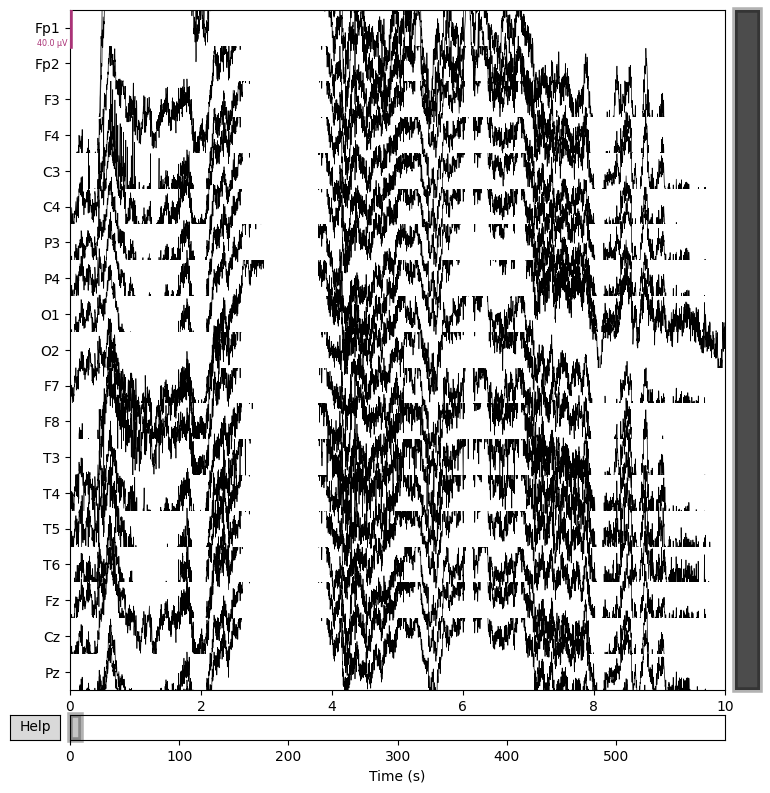

In [1]:
import mne

# Replace 'your_file.set' with the path to your .set file
eeg_data = mne.io.read_raw_eeglab('ds004504-download/sub-001/eeg/sub-001_task-eyesclosed_eeg.set', preload=True)

# Print a summary of the data
print(eeg_data.info)

# Plot the raw EEG data
eeg_data.plot()

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F3, F4, C3, C4, P3, P4, O1, O2, F7, F8, T3, T4, T5, ...
 chs: 19 EEG
 custom_ref_applied: False
 dig: 22 items (3 Cardinal, 19 EEG)
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 19
 projs: []
 sfreq: 500.0 Hz
>


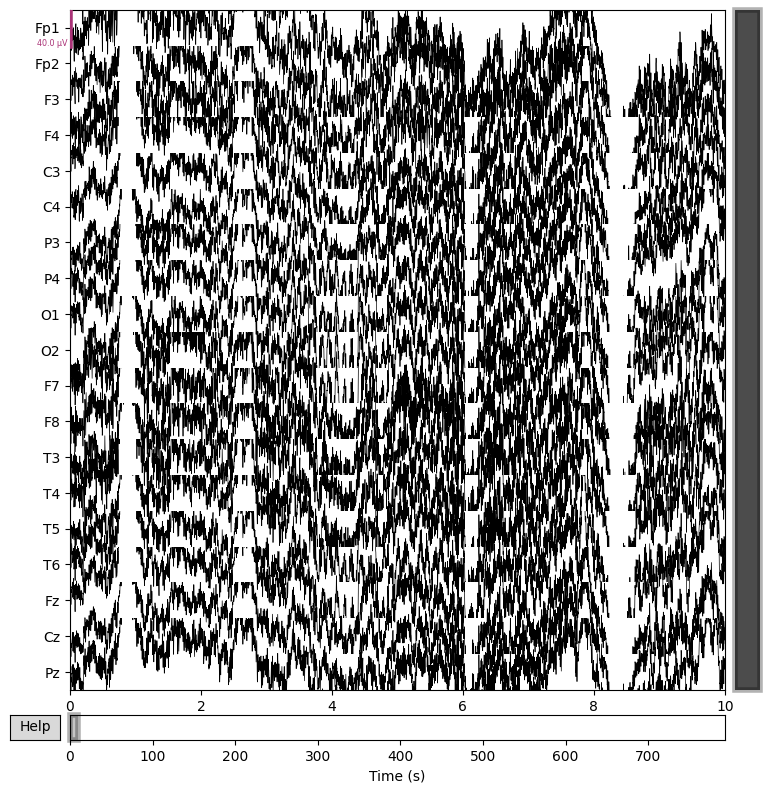

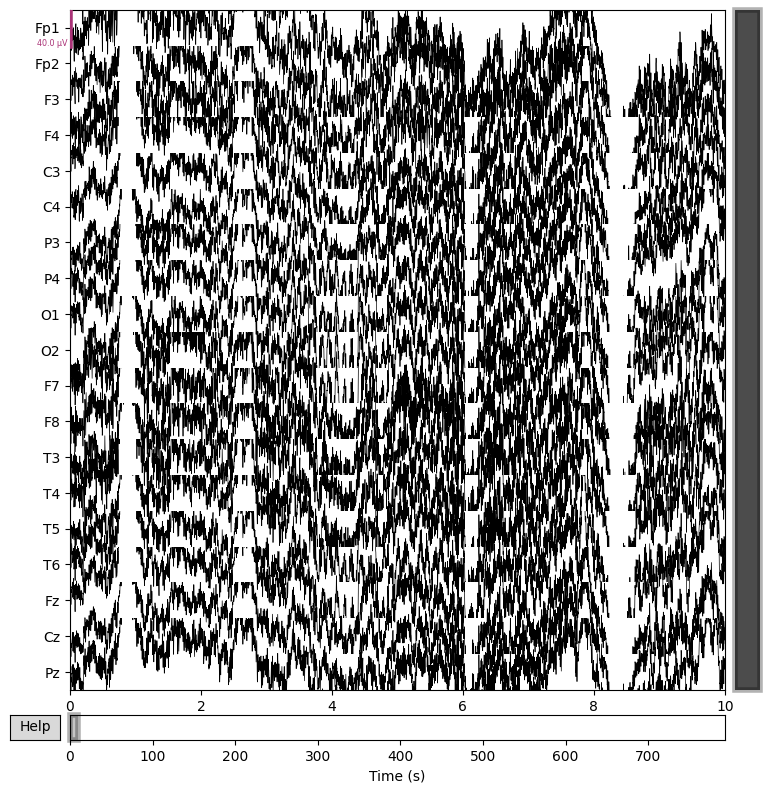

In [2]:
eeg_data_2 = mne.io.read_raw_eeglab(f'ds004504-download/sub-002/eeg/sub-002_task-eyesclosed_eeg.set', preload=True)
print(eeg_data_2.info)
eeg_data_2.plot()

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

full_data = [mne.io.read_raw_eeglab(f'ds004504-download/sub-{"{:03}".format(i)}/eeg/sub-{"{:03}".format(i)}_task-eyesclosed_eeg.set', preload=True).get_data() for i in range(1, 89)]

shapes = torch.tensor([dat.shape for dat in full_data])
min_length = torch.min(shapes[:, 1])
min_length = min_length // 10_000 * 10_000

num_samples = min_length
num_channels = shapes[0, 0]

# truncate each data to the minimum length
# each data has the shape (19, num_samples)

full_data_truncated = [dat[:, :min_length] for dat in full_data]
del full_data
full_data = torch.tensor(full_data_truncated).float().to("mps")
del full_data_truncated

/var/folders/3n/sjbgw9357l188k3xlvvxhwyc0000gn/T/ipykernel_50316/2949443846.py:21: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  full_data = torch.tensor(full_data_truncated).float().to("mps")


In [4]:
print(full_data.shape) # batch_dim, channel_dim, time_dim

torch.Size([88, 19, 150000])


In [5]:
import torch
import torch.nn as nn

class TemporalBlock(nn.Module):
    """A smaller temporal block for the TCN with dilated convolutions and residual connections."""
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=stride, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = nn.Conv1d(in_channels, out_channels, kernel_size=1) if in_channels != out_channels else None
    
    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        if self.downsample is not None:
            x = self.downsample(x)
        return out + x

class TCNEncoder(nn.Module):
    """A smaller TCN encoder for more efficient training."""
    def __init__(self, num_channels, latent_dim):
        super(TCNEncoder, self).__init__()
        # Reduced the number of channels in each block
        self.tcn = nn.Sequential(
            TemporalBlock(num_channels, 8, kernel_size=3, stride=1, dilation=1, padding=1),
            TemporalBlock(8, 16, kernel_size=3, stride=1, dilation=2, padding=2),
            TemporalBlock(16, 32, kernel_size=3, stride=1, dilation=4, padding=4),
            nn.AdaptiveAvgPool1d(1),  # Reduce to (N, 32, 1)
            nn.Flatten(),
            nn.Linear(32, latent_dim // 4)  # Reduced hidden units to reduce params
        )
    
    def forward(self, x):
        return self.tcn(x)

class TCNDecoder(nn.Module):
    """A smaller TCN decoder to match the encoder structure."""
    def __init__(self, latent_dim, num_channels):
        super(TCNDecoder, self).__init__()
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim // 4, 32),  # Reduced size
            nn.Unflatten(1, (32, 1)),
            nn.ConvTranspose1d(32, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(8, num_channels, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        # Adding a final linear layer to map to the desired output size of 3
        self.final_layer = nn.Linear(num_channels, 3)

    def forward(self, x):
        # Pass through the decoder
        x = self.decoder(x)
        # Average pooling to reduce to a manageable size if necessary (depends on input length)
        x = x.mean(dim=-1)  # Averaging over the last dimension to match the final linear layer input size
        # Final layer to map to 3 output classes
        x = self.final_layer(x)
        # Apply softmax activation for output
        return x
class TCN_Classifier(nn.Module):
    """Compact TCN Classifier suitable for long sequence data on lower-end hardware."""
    def __init__(self, num_channels, latent_dim=512):
        super(TCN_Classifier, self).__init__()
        self.encoder = TCNEncoder(num_channels, latent_dim)
        self.decoder = TCNDecoder(latent_dim, num_channels)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [6]:

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd

# Prepare data
participants = pd.read_csv('ds004504-download/participants.tsv', sep='\t')

num_channels, num_samples = full_data.shape[1], full_data.shape[2]
labels = participants["Group"]

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    full_data, encoded_labels, test_size=0.4
)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_val, dtype=torch.long)

# Create DataLoaders
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model, Loss, and Optimizer setup
model = TCN_Classifier(num_channels, num_samples).float().to("mps")  # Ensure model is on the correct device
criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss is more appropriate for classification
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.05)

# Training Loop
num_epochs = 100
device = torch.device("mps")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Forward pass
        encoded, logits = model(inputs)  # Correctly passing encoded and logits
        loss = criterion(logits, labels)  # Computing loss on logits

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(logits, 1)  # Correctly use logits for prediction
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    # Validation step
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in val_loader:
            val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
            
            val_encoded, val_logits = model(val_inputs)  # Get validation logits
            v_loss = criterion(val_logits, val_labels)  # Use logits for validation loss
            
            val_loss += v_loss.item()
            _, val_predicted = torch.max(val_logits, 1)  # Correctly use logits
            val_total += val_labels.size(0)
            val_correct += (val_predicted == val_labels).sum().item()

    # Print epoch results
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {running_loss/len(train_loader):.4f}, "
          f"Train Accuracy: {100 * correct/total:.2f}%, "
          f"Val Loss: {val_loss/len(val_loader):.4f}, "
          f"Val Accuracy: {100 * val_correct/val_total:.2f}%")

/var/folders/3n/sjbgw9357l188k3xlvvxhwyc0000gn/T/ipykernel_50316/2408703476.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train, dtype=torch.float32)
/var/folders/3n/sjbgw9357l188k3xlvvxhwyc0000gn/T/ipykernel_50316/2408703476.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(X_val, dtype=torch.float32)


Epoch 1/100, Train Loss: 1.0978, Train Accuracy: 28.85%, Val Loss: 1.0794, Val Accuracy: 38.89%
Epoch 2/100, Train Loss: 1.1020, Train Accuracy: 28.85%, Val Loss: 1.0798, Val Accuracy: 38.89%
Epoch 3/100, Train Loss: 1.0987, Train Accuracy: 28.85%, Val Loss: 1.0802, Val Accuracy: 38.89%
Epoch 4/100, Train Loss: 1.0912, Train Accuracy: 28.85%, Val Loss: 1.0806, Val Accuracy: 38.89%
Epoch 5/100, Train Loss: 1.0937, Train Accuracy: 28.85%, Val Loss: 1.0810, Val Accuracy: 38.89%
Epoch 6/100, Train Loss: 1.0954, Train Accuracy: 32.69%, Val Loss: 1.0814, Val Accuracy: 38.89%
Epoch 7/100, Train Loss: 1.0917, Train Accuracy: 40.38%, Val Loss: 1.0817, Val Accuracy: 38.89%
Epoch 8/100, Train Loss: 1.0835, Train Accuracy: 44.23%, Val Loss: 1.0820, Val Accuracy: 38.89%
Epoch 9/100, Train Loss: 1.0965, Train Accuracy: 44.23%, Val Loss: 1.0824, Val Accuracy: 38.89%
Epoch 10/100, Train Loss: 1.0819, Train Accuracy: 48.08%, Val Loss: 1.0828, Val Accuracy: 38.89%
Epoch 11/100, Train Loss: 1.0750, Train

KeyboardInterrupt: 

In [7]:
import pandas as pd
import numpy as np

participants = pd.read_csv('ds004504-download/participants.tsv', sep='\t')
encoder = model.encoder
diagnosis = participants['Group']

# encode all the data
encoded_data = []
for dat in full_data:
    encoded = encoder(dat.unsqueeze(0)).detach().cpu().numpy()
    encoded_data.append(encoded)

encoded_data = torch.tensor(encoded_data).squeeze(1)

/Users/sudarshanagopalkunnavakkam/Documents/Github/brain/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
python(50637) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


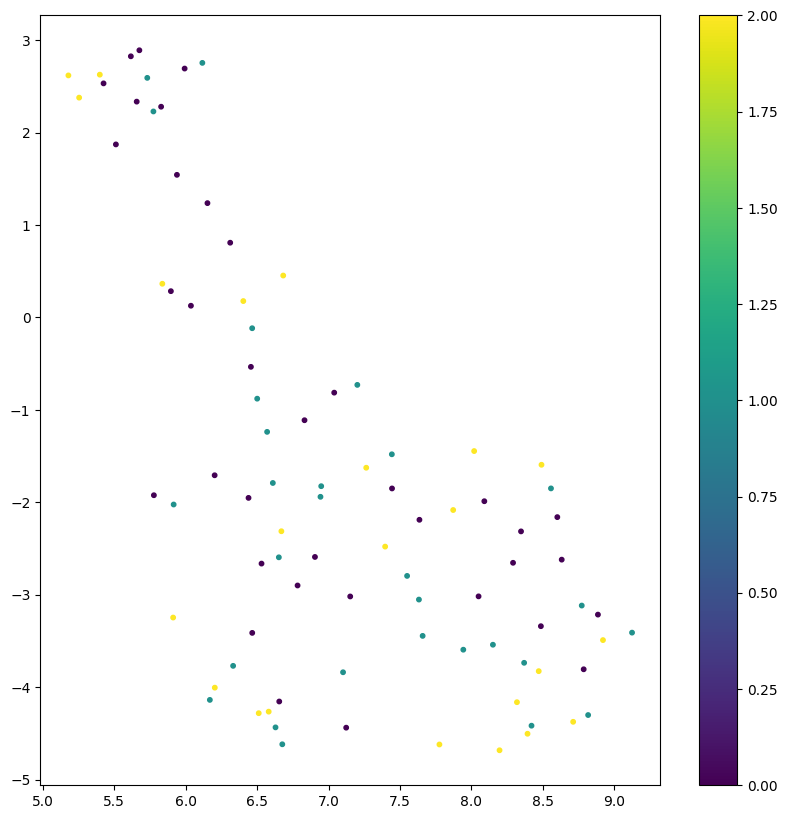

In [8]:
# umap
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(encoded_data)

# plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(embedding[:, 0], embedding[:, 1], c=encoded_labels, cmap='viridis', s=10)
plt.colorbar()
plt.show()